In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import pos_tag, word_tokenize
import seaborn as sns

In [2]:
pd.set_option('display.max_colwidth',15)

In [3]:
def word_prep(df):
    #identify all possible special characters
    punc = ['!','@','#','$','%','^','&','*','(',')','-','_','+','=','{',
            '[','}',']',"\"","/",',',"<",">",';',':',"'",'"','`','~','?','', '\\', '.']

    #replace the special characters in words with blanks
    for i in punc:
        df = df.str.replace(i,'')

    return (df)

## IMPORT DATA

In [4]:
# reviews = pd.read_csv('C:/Users/abbas/Google Drive/CIS511/project/data/X_train.csv', sep = '|')
reviews = pd.read_csv('C:/Users/abbas/Google Drive/CIS511/project/data/X_train.csv',  sep = '|')
# /content/drive/Shareddrives/NLP/X_train.csv

In [5]:
reviews_scores = pd.read_csv('C:/Users/abbas/Google Drive/CIS511/project/data/y_train.csv', sep = '|')

In [6]:
reviews = pd.merge(reviews,reviews_scores, on = 'review_num', how = 'inner')
reviews['Text'] = reviews['Text'].str.lower()
reviews['Text1'] = reviews['Text'].copy()

In [7]:
reviews['Text'] = word_prep(reviews['Text'])

In [8]:
reviews = reviews.reset_index()

## Puncuation EDA

In [ ]:
reviews['has_exclam'] = np.where(reviews.Text1.str.contains('!'),1,0)
reviews['has_quest'] = np.where(reviews.Text1.str.contains('\?'),1,0)

In [ ]:
reviews['exclam_count'] = reviews.Text1.str.count('!')
reviews['quest_count'] = reviews.Text1.str.count('\?')

In [ ]:
reviews['exclam_count'] = np.where(reviews['exclam_count'] > 10, 10, reviews['exclam_count'])
reviews['quest_count'] = np.where(reviews['quest_count'] > 10, 10, reviews['quest_count'])

<ipython-input-138-6aac17378171>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  x = reviews.groupby(['Score'])['has_exclam','ProductId'].agg({'has_exclam':'sum',


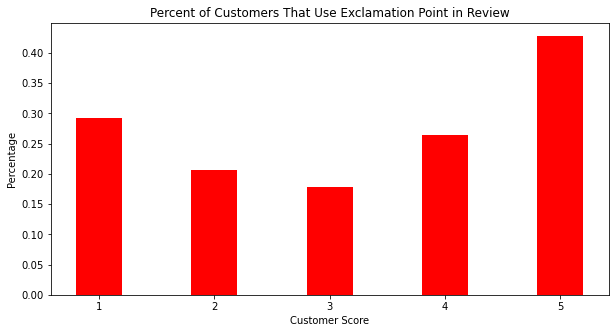

In [ ]:
x = reviews.groupby(['Score'])['has_exclam','ProductId'].agg({'has_exclam':'sum',
                                                         'ProductId':'count'}).reset_index()
x['percent'] = x['has_exclam'] / x['ProductId']

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x['Score'], x['percent'], color ='red',
        width = 0.4)
 
plt.xlabel("Customer Score")
plt.ylabel("Percentage")
plt.title("Percent of Customers That Use Exclamation Point in Review")
plt.savefig('percent_of_customers_with_exclamation_mark.png', dpi = 100)
plt.show()

<ipython-input-136-09b316728ae5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  x = reviews.groupby(['Score'])['has_quest','ProductId'].agg({'has_quest':'sum',


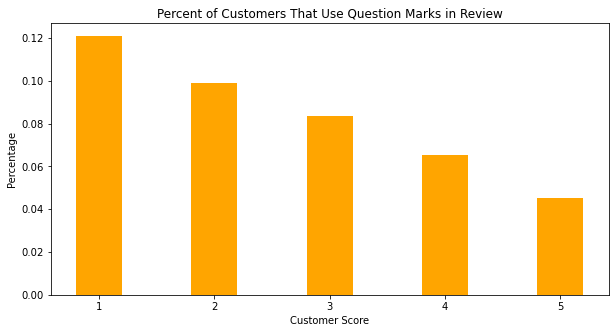

In [ ]:
x = reviews.groupby(['Score'])['has_quest','ProductId'].agg({'has_quest':'sum',
                                                         'ProductId':'count'}).reset_index()
x['percent'] = x['has_quest'] / x['ProductId']

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x['Score'], x['percent'], color ='orange',
        width = 0.4)
 
plt.xlabel("Customer Score")
plt.ylabel("Percentage")
plt.title("Percent of Customers That Use Question Marks in Review")
plt.savefig('percent_of_customers_with_question_mark.png', dpi = 100)
plt.show()


In [ ]:
x = reviews.loc[reviews['exclam_count'] > 0].groupby(['Score','exclam_count'])['ProductId'].count().reset_index()
pd.pivot_table(x, values = 'ProductId',index = 'Score', columns = 'exclam_count', aggfunc = 'first').to_excel('exclamation_counts.xlsx', index = False)

In [ ]:
x = reviews.loc[reviews['quest_count'] > 0].groupby(['Score','quest_count'])['ProductId'].count().reset_index()
pd.pivot_table(x, values = 'ProductId',index = 'Score', columns = 'quest_count', aggfunc = 'first').to_excel('question_mark_counts.xlsx', index = False)

## WORDS EDA

In [9]:
# convert each word in a sentence into a row

### first: split each word in a row into a column
words = reviews['Text'].str.split(' ', expand = True)
words = words.reset_index()

### second: convery the columns into rows
words = words.melt(['index']).copy()
words.sort_values(by = ['index','variable'], ascending = True, inplace = True)

In [10]:
words = words.loc[~(words['value'].isna())]
words = words.loc[~(words['value'].isin(['',' ']))]

In [11]:
words = pd.merge(words, reviews.loc[:,['index','review_num','ProductId','Score']], on = 'index', how = 'inner')

### Distribution of Scores

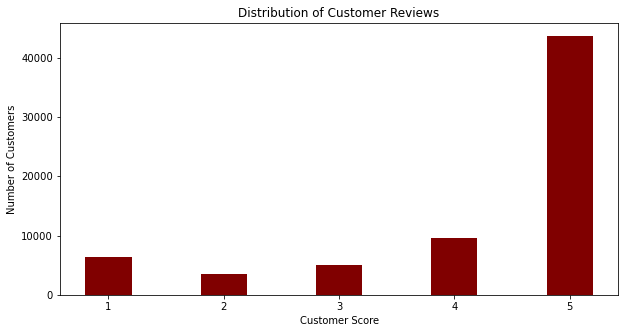

In [19]:
x = reviews.Score.value_counts().reset_index()
x.sort_values(by = ['index'], inplace = True)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x['index'], x['Score'], color ='maroon',
        width = 0.4)
 
plt.xlabel("Customer Score")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customer Reviews")
plt.savefig('customer_review_dist.png', dpi = 100)
plt.show()

In [18]:
x

,index,Score
2,1,6297
4,2,3561
3,3,5048
1,4,9640
0,5,43667


### Number of Words per Score

In [21]:
reviews['number_of_words'] = reviews.Text.apply(lambda n: len(n.split()))

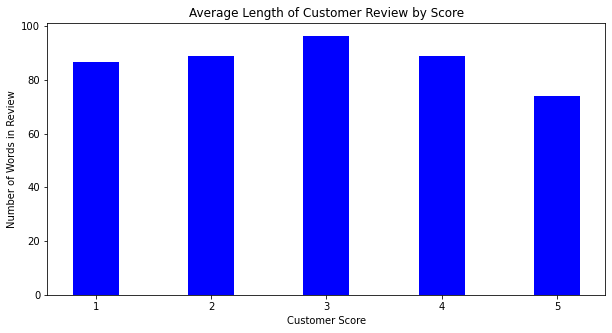

In [22]:
x = reviews.groupby(['Score'])['number_of_words'].describe().reset_index()

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x['Score'], x['mean'], color ='blue',
        width = 0.4)
 
plt.xlabel("Customer Score")
plt.ylabel("Number of Words in Review")
plt.title("Average Length of Customer Review by Score")
plt.savefig('customer_review_length_dist.png', dpi = 100)
plt.show()

### Distribution of POS Per Score

In [12]:
reviews_samp = reviews.sample(frac = 0.1, random_state = 1).copy()
words_samp = words.loc[words['index'].isin(reviews_samp['index'])].copy()

In [ ]:
#tokenize the words
tokens = (words_samp['value'].apply(word_tokenize).to_list())

# classify the type of word
tags = []
for i in range(len(tokens)):
    x,y = zip(*(pos_tag(tokens[i])))
    tags.append(y[0])
    if i%100000 == 0:
        print(i)
#join the classification of each word back to the main "periods" dataframe
words_samp['tags'] = tags

0
100000
200000
300000


In [ ]:
x = words_samp.groupby(['Score','tags'])['variable'].count().reset_index().copy()
x_tot = words_samp.Score.value_counts().reset_index().copy()
x_tot.rename(columns = {'Score':'total_count',
                       'index':'Score'}, inplace = True)

x = pd.merge(x,x_tot, on = 'Score', how = 'inner')
x['perc'] = x['variable'] / x['total_count']

In [ ]:
pd.pivot_table(x, values = 'perc',index = 'Score', columns = 'tags', aggfunc = 'first').to_excel('POS_tags_by_score.xlsx')

In [ ]:
pd.pivot_table(words_samp, values = 'variable',index = 'Score', columns = 'tags', aggfunc = 'count').to_excel('POS_tags_by_score)count.xlsx')

### Top Verbs per Score

In [ ]:
list_verbs = ['VB','VBG','VBD','VBN','VBP','VBZ']

common_verbs = ['is','ask','be','can',
                'come','could','do',
                'have', 'were','will','would', 'are','was','has','had','am']

verbs = words_samp.loc[words_samp['tags'].isin(list_verbs)].copy()
verbs = verbs.loc[~(verbs['value'].isin(common_verbs))].copy()

verbs = verbs.groupby(['Score','value'])['tags'].count().reset_index()
verbs.sort_values(by = ['Score','tags'], ascending = [True,False], inplace = True)

top_verbs = pd.DataFrame()
for i in range(5):
    holder = verbs.loc[verbs['Score'] == (i+1)].head(15)
    top_verbs = pd.concat([top_verbs,holder], axis = 0)
    
top_verbs.to_excel('Top_5_Verbs_Per_Score.xlsx')

### Top Adjectives per Score

In [ ]:
list_adj = ['JJ','JJR','JJS']

adj = words_samp.loc[words_samp['tags'].isin(list_adj)].copy()


adj = adj.groupby(['Score','value'])['tags'].count().reset_index()
adj.sort_values(by = ['Score','tags'], ascending = [True,False], inplace = True)

top_adj = pd.DataFrame()
for i in range(5):
    holder = adj.loc[adj['Score'] == (i+1)].head(5)
    top_adj = pd.concat([top_adj,holder], axis = 0)
    
top_adj.to_excel('Top_5_Adj_Per_Score.xlsx')